<a href="https://colab.research.google.com/github/MaCoZu/NLP/blob/main/02_imdb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

In [14]:
import matplotlib.pyplot as plt
import numpy as np

In [26]:
datasets, info = tfds.load(
    "imdb_reviews/plain_text",
    split=["train", "test[:50%]", "test[50%:]"],
    as_supervised=True,
    with_info=True
)

dataset_train_original = datasets[0]
dataset_validate_original = datasets[1]
dataset_test_original = datasets[2]

In [27]:
for review, label in dataset_train_original.take(5):
  print(review.numpy().decode("utf-8"))
  print(label.numpy())
  print("-"*80)

This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.
0
--------------------------------------------------------------------------------
I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this

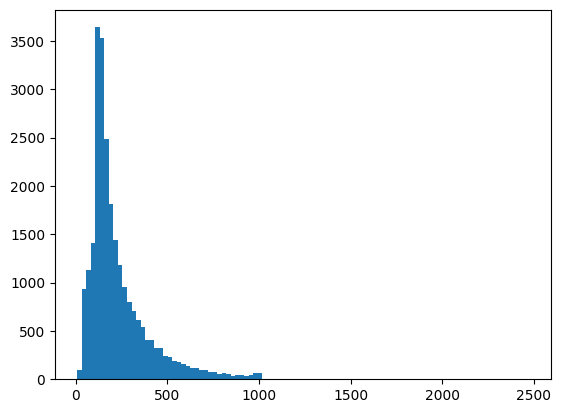

In [29]:
lenghts = []
for x, _ in dataset_train_original:
  x = x.numpy().decode("utf-8")
  lenghts += [len(x.split())]

plt.hist(lenghts, bins=100)
plt.show()

In [30]:
print('Min:', np.min(lenghts))

Min: 10
